In [1]:
# %matplotlib inline
%matplotlib notebook
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
from collections import OrderedDict as OD
import math
from scipy.interpolate import interp1d as interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import os

In [2]:
# Set plot defaults:
mpl.rcParams['figure.figsize'] = [8.0, 5.0]
savefigw = 11.2
savefigh = 7.
mpl.rcParams['font.size'] = 13
mpl.rcParams['lines.linewidth'] = 3
# mpl.rcParams['legend.fontsize'] = 'small'

plt.rcParams["text.usetex"] = False

# mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'normal'
mpl.rcParams['axes.labelsize'] = 20
# mpl.rcParams['axes.labelweight'] = 'heavy'

mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['xtick.major.size'] = 6.5
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.minor.size'] = 4.0
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['ytick.major.size'] = 6.5
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.minor.size'] = 4.0


In [ ]:
mpl.rcParams.keys()

In [3]:
datadir = '/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/plotsdata/Glue'
plotdir = '/Users/troyraen/Documents/Talks/WIMP_Paper'
finalplotdir = '/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/plots'
fzams = datadir+ '/zams.csv'
fdesc = datadir+ '/descDF_MS_allmassesreg.csv'
profiles_datadir = '/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/'
iso_csv = '/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/isochrones/isochrones.csv'

# Helper Fncs

In [4]:
# Cboost colormap and colorbar

# used in plt.plot and other places to normalize colorbar
vmin=-0.5
vmax=6.5

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """ Returns a new color map, trucated at min/maxval."""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def get_cmap_color(val, cmap=None):
    """ Returns rgba color of val in cmap normalized to global vmin, vmax"""
    if cmap==None:
        cmap = cbcmap
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    rgba = cmap(norm(val))
    return rgba

def get_cmapdict(cb,l):
    """ Returns a dict to be used as kwargs in plt.plot.
        all get the same color (specific cb)
    """
    if l == 1:
        return {'c':cb, 'cmap':cbcmap, 'vmin':vmin, 'vmax':vmax}
    else:
        return {'c':cb*np.ones(l), 'cmap':cbcmap, 'vmin':vmin, 'vmax':vmax}

def get_cbcbar(sm=None, cax=None, f=None, **kwargs):
    """ Returns a colorbar that will be added to the side of a plot.
        Intended to be used with plotting that uses cbcmap as the colormap.
        
        Pass cax = subplot axis if using on figure with subplots
        Example:
                f.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, \
                                                    wspace=0.02, hspace=0.02)
                cb_ax = f.add_axes([0.83, 0.1, 0.02, 0.8])
                cbar = get_cbcbar(sm=ascat, cax=cb_ax, f=f)

    """
    cbar = plt.colorbar(sm, **{'pad':0.01}, **kwargs) if cax is None \
            else f.colorbar(sm, cax=cax, **kwargs)
    cbar.set_ticks([0,1,2,3,4,5,6],update_ticks=False)
    cbar.set_ticklabels(['NoDM',r'$10^1$',r'$10^2$',r'$10^3$',r'$10^4$',r'$10^5$',r'$10^6$'])
    cbar.ax.minorticks_off()
    cbar.set_label(r'$\Gamma_B$', labelpad=-5)
    return cbar

# Create cboost colormap (cbcmap):
cmapinf = plt.get_cmap('inferno_r')
cmapinftrunc = truncate_colormap(cmapinf, 0.2, 0.8)
cmapblues = plt.get_cmap('Blues')
c0c = get_cmap_color(0, cmap=cmapinftrunc)
c1c = get_cmap_color(1, cmap=cmapinftrunc)
c2c = get_cmap_color(2, cmap=cmapinftrunc)
c3c = get_cmap_color(3, cmap=cmapblues)
c4c = get_cmap_color(5, cmap=cmapblues)
c5c = get_cmap_color(4, cmap=cmapinftrunc)
c6c = get_cmap_color(6, cmap=cmapinftrunc)
carr = (c0c,c1c,c2c,c3c,c4c,c5c,c6c)
cbcmap = ListedColormap(carr)


In [59]:
def fix_desc_mass(descdf):
    descdf['mass'] = descdf.apply(get_mass_from_idx, axis=1)
    return descdf

    
def get_mass_from_idx(row):
    #     get star id
    idx = int(row['star_index'])
#     print('\nindex {0}, start mass {1}'.format(idx, row['mass']))

    #     parse to get mass
    mint = str(idx)[:-3]
    if int(mint[0])>5 or len(mint)==1:
        mass = float('0.'+mint)
    else:
        mass = float(mint[0]+'.'+mint[1:])
#     print('\tnew mass {}'.format(mass))
    return mass

In [ ]:
# NOT USING
# Function taken from
# https://stackoverflow.com/questions/19522004/building-a-dictionary-from-directory-structure
import sys
import os
from stat import *


def PathToDict(path):
    st = os.stat(path)
    result = {}
    result['active'] = True
    #result['stat'] = st
    result['full_path'] = path
    if S_ISDIR(st.st_mode):
        result['type'] = 'd'
        result['items'] = {
            name : PathToDict(path+'/'+name)
            for name in os.listdir(path)}
    else:
        result['type'] = 'f'
    return result

### Profiles

In [6]:
def get_pidx(cb, modnum, mass=3.5):
    return 'm{mass}c{cb}mod{modnum}'.format(mass=mass, cb=cb, modnum=modnum)

def get_profile_path(row):
    """ row should be a row from df pidxdf.
        Returns path to the profile#.data file"""
    path = row.path_to_LOGS
    pnum = row.profile_number
    fprof = path+ '/profile'+ str(pnum)+ '.data'
    return fprof

In [7]:
def get_profilesindex_df(profile_runs_dir=profiles_datadir):
    """ Returns a df of all profiles.index files in path profile_runs_dir.
            Columns are { mass, cb, path_to_LOGS, priority, model_number, profile_number }
        Assumes particular path structure, 
            as written by mesa_wimps script ./bash_scripts/profile_run.sh
    """
    pidx_cols = ['model_number', 'priority', 'profile_number']
    
    dflist = []
    for cb in os.listdir(profile_runs_dir):
        if cb[0] == '.': continue # skip hidden directories
        cbpath = profile_runs_dir+ cb
        for mass in os.listdir(cbpath):
            if mass[0] == '.': continue # skip hidden directories
            Lpath = cbpath+'/'+ mass+'/'+'LOGS'
            fpidx = Lpath+ '/profiles.index'
            try:
                df = pd.read_csv(fpidx, names=pidx_cols, skiprows=1, header=None, sep='\s+')
            except:
                strsplit = fpidx.split('/') # don't print the whole path
                print('Skipping {cb} dir {s}'.format(cb=cb, s=strsplit[-3]))
                continue

#             add mass, cb, and path
            tmp = mass.split('_', maxsplit=1)[0][1:]
            mass_float = float(tmp[0]+'.'+tmp[2:])
            df['mass'] = mass_float
            df['cb'] = int(cb[1])
            df['path_to_LOGS'] = Lpath
            
            dflist.append(df)

    return pd.concat(dflist, ignore_index=True)

pidxdfOG = get_profilesindex_df()

Skipping c3 dir m1p00_stopmod1


In [8]:
def get_meta_df(pidxdf=None):
    """ Returns df of metadata of all profiles in pidxdf
        Looks up path to files in pidxdf (as returned by get_profilesindex_df().
    """
#     Get correct rows from pidxdf
    try:
        p = pidxdf if pidxdf is not None else pidxdfOG
        assert type(p)==pd.DataFrame
        
    except:
        print('Getting get_profilesindex_df()...')
        p = get_profilesindex_df()
        
        
    dflist = []
    # Get the metadata:
    for i, row in p.iterrows():
        fprof = get_profile_path(row)
        try:
            metadf = pd.read_csv(fprof, header=1, sep='\s+', nrows=1)
        except:
            print(fprof, 'metadata cannot be loaded')
            
        idx = get_pidx(row.cb, row.model_number)
        metadf['pidx'] = str(idx)
        metadf['cb'] = row.cb
        metadf['path'] = fprof

        dflist.append(metadf)
#         break

    df = pd.concat(dflist, ignore_index=True)
    df.set_index('pidx', inplace=True, drop=False)
    return df

        
mdf = get_meta_df()

In [9]:
def load_prof_from_file(cb, modnum, mass=3.5, pidxdf=None):
    """ Returns profile index and 2 dfs (df and metadf) from profile#.data info.
        Looks up path to file in pidxdf (as returned by get_profilesindex_df().
    """
#     Get correct rows from pidxdf
    try:
        p = pidxdf if pidxdf is not None else pidxdfOG
        assert type(p)==pd.DataFrame
        
    except:
        print('Getting get_profilesindex_df()...')
        p = get_profilesindex_df()
    req = p.loc[(p.mass==mass) & (p.cb==cb) & (p.model_number==modnum)] # df with rows matching input
    if len(req)>1:
        print('Found {n} rows matching input m{mass} c{cb} mod{mod}. Paths are: \
                \n{path}\n\nUsing the last.'
              .format(n=len(req), mass=mass, cb=cb, mod=modnum, path=req.path_to_LOGS.values))
    
#     Load data and meta_data to dfs
    try:
        row = req.iloc[-1]
        fprof = get_profile_path(row) # Get path to profile#.data

        df = pd.read_csv(fprof, header=4, sep='\s+')
        df['path'] = fprof
        metadf = pd.read_csv(fprof, header=1, sep='\s+', nrows=1)
        metadf['path'] = fprof
    except:
        print('Profile for m{mass}, c{cb}, mod{mod} does not seem to exist.'.format(
                                                        mass=mass, cb=cb, mod=modnum))
        
    idx = get_pidx(cb, modnum, mass=mass)

    return [idx, df, metadf]


In [10]:
# dictionary of loaded profile#.data dfs
pdfs = {}
# main key: profile index as returned by load_prof_from_file
# main value: dict with keys/values: idx, df, metadf

def get_pdf(cb, modnum, mass=3.5, rtrn='df'):
    """ Returns profile#.data as df. Loads from file if needed.
        rtrn =  'metadf' returns the metadf
                'idx' returns the profile index
                'all' returns all three as a list
    """
    pidx = get_pidx(cb, modnum, mass=mass)
    try:
        idx = pdfs[pidx]['idx']
        df = pdfs[pidx]['df']
        metadf = pdfs[pidx]['metadf']
    except:
        idx, df, metadf = load_prof_from_file(cb, modnum, mass=mass) # load from file
        pdfs[idx] = {} # save to dict
        pdfs[idx]['df'] = df
        pdfs[idx]['metadf'] = metadf
    
    if rtrn == 'df':
        return df
    if rtrn == 'metadf':
        return metadf
    if rtrn == 'idx':
        return idx
    if rtrn == 'all':
        return [idx, df, metadf]

In [11]:
def get_h1_modnums(frm='profile_metadata', mass=3.5, hdf=None, cb=None):
    """ Returns dict, key = cb, val = list of model numbers corresponding to 
                                        center_h1 cuts in dict h1cuts = get_h1cuts()
        frm = 'profile_metadata' uses mdf for look up
        frm = 'history_data' uses a history df (must pass hdf and cb)
    """
    h1cuts = get_h1cuts()
    cbmods = {} # dict of lists of model numbers

    if frm == 'history_data':
        mods = []
        for name, h1c in h1cuts.items():
            try:
                # Get the first model number after center_h1 < h1c:
                tmp = hdf[hdf.center_h1<h1c].sort_values('model_number').model_number
                mods.append(tmp.iloc[0])
            except IndexError:
                print()
                print(name, 'no model with center_h1 < ', h1c)
                print('setting modnum to NaN')
                mods.append(float('NaN'))
            except:
                print()
                print('Make sure you passed a valid hdf to get_h1_modnums.')
        cbmods[cb] = mods
                
    
    elif frm == 'profile_metadata':
        cbg = mdf[mdf.initial_mass==mass].groupby('cb', sort=True) # ensure sorted by cb value
        for i, (cb, df) in enumerate(cbg):
            mods = [] # list of model numbers
            for name, h1c in h1cuts.items():
                try:
                    # Get the first model number after center_h1 < h1c:
                    tmp = df[df.center_h1<h1c].sort_values('model_number').model_number
                    mods.append(tmp.iloc[0])
                except IndexError:
                    print()
                    print(cb, name, 'no model with center_h1 < ', h1c)
                    print('setting modnum to NaN')
                    mods.append(float('NaN'))

            cbmods[cb] = mods
    else:
        print('Must pass valid argument with frm. (profile_metadata or history_data)')

    return cbmods


def get_h1cuts():
    """ Returns OD of h1 cuts to find profile model numbers"""
    start_center_h1 = 0.718 # this is the same for all models

    # define h1 cuts to find profile model numbers
    # taken from Dotter where possible
    h1cuts = OD([('ZAMS',start_center_h1 - 0.0015), 
                 ('IAMS',0.3), 
                 ('H-1',1e-1), 
                 ('H-2',1e-2), 
                 ('H-3',1e-3), 
                 ('H-4',1e-4), 
                 ('H-6',1e-6), 
                 ('TAMS',1e-12)])

    return h1cuts

### History

In [26]:
def get_hidx(cb,mass=1.0):
    return 'm{mass}c{cb}'.format(mass=mass, cb=cb)

def load_hist_from_file(cb, mass=1.0, from_file=True, pidxdf=None):
    """ Returns df of history.data from LOGS dir of 
            highest model number matching cb, mass (to get most copmlete data).
            
        from_file = string forces reload from disk using LOGS dir 
                inside dir string (e.g. 'm1p00_stopmod10000')
            
        Send pidxdf = [] (or other type) to force it to reload from disk
    """
    hidx = get_hidx(cb, mass=mass)
    print('Loading {} history df from file. Looking for path...'.format(hidx))


    # Get pidxdf
    try:
        p = pidxdf if pidxdf is not None else pidxdfOG
        assert type(p)==pd.DataFrame
    except:
        print('Getting get_profilesindex_df()...')
        p = get_profilesindex_df()
        
    # Get path to LOGS dir
    try:
        mcb_mods = p[(p.mass==mass) & (p.cb==cb)][['model_number','path_to_LOGS']]
        if type(from_file) == str: # get the one from the dir matching from_file
            dirlist = list((mcb_mods.groupby('path_to_LOGS')).groups.keys())
            for dl in dirlist:
                finaldir = dl.split('/')[-2]
                if finaldir == from_file:
                    Lpath = dl
                    print('Found requested dir: ', from_file)
                    continue
            
        else: # get the one with the highest model number
            Lpath = mcb_mods.sort_values('model_number').iloc[-1].path_to_LOGS
            
        assert type(Lpath) == str
        
    except:
        print('No models matching m{mass} c{cb} dir {ff} in pidxdf'.format(mass=mass, cb=cb, ff=from_file))
        print('Specific dir requested: {ff}'.format(ff=from_file))

    # Load history.data
    try:
        hpath = Lpath+ '/history.data'
        print('Loading history df from path {}'.format(hpath))
        df = pd.read_csv(hpath, header=4, sep='\s+')
    except:
        print(hpath, 'not loaded')
        
    print()

    return df

In [32]:
hdfs = {} # holds loaded history dataframes
def get_hdf(cb, mass=1.0, from_file=False):
    """ Returns history.data file as df from loaded dict.
        Loads data from file if necessary, getting the file
            with the largest model number in pidxdf.
                
        from_file == True forces reload from disk using LOGS dir with 
                highest model number matching cb, mass (to get most complete data).
        from_file == string forces reload from disk using LOGS dir 
                inside dir string (e.g. 'm1p00_stopmod1000')
    """
    
    hidx = get_hidx(cb, mass=mass)
    try:
        hdf = hdfs[hidx]
        if from_file != False:
            hdf = [] # change type to force reload from file
        assert type(hdf) == pd.DataFrame
    except:
        hdf = load_hist_from_file(cb, mass=mass, from_file=from_file, pidxdf=[])
        hdf['cb'] = cb
        hdf['hidx'] = hidx
        hdf.set_index('hidx', drop=False, inplace=True)
        if type(from_file) != str: # do not write to master hdfs if from_file is a string (used for burning cols)
            hdfs[hidx] = hdf
        
    return hdf
    

In [14]:
def get_burn_cols(hdf):
    """ Returns df with cols {star_age, burn_type, mass_top, mass_bottom}
                where mass_ is mass coord in [Msun] (converts q to mass(<r)).
        Ensures burn zone matches burn type.
        """
#     concat burn columns, check that have 1 time step for every burn type

    hdf.set_index('star_age', inplace=True, drop=False)
    
    btcols = sorted([ col for col in hdf.columns if 'burn_type' in col ])
    bqtcols = sorted([ col for col in hdf.columns if 'burn_qtop' in col ])
    dflist = []
    for i in range(len(btcols)):
        bt_name = btcols[i]
        bqt_name = bqtcols[i]

        bt = hdf[bt_name]
        ages = hdf.star_age
        
        # get burn zone coords
        burn_qtop = hdf[bqt_name]
        if i == 0:
            burn_qbottom = 0*burn_qtop
        else:
            burn_qbottom = hdf[bqtcols[i-1]]
        # convert to Msun
        mass_top = burn_qtop*hdf.star_mass
        mass_bottom = burn_qbottom*hdf.star_mass
        
        col_list = OD([('star_age',ages), ('burn_type',bt), 
                       ('mass_top',mass_top), ('mass_bottom',mass_bottom)])
#         print([col_list[i].sample() for i in range(len(cols))])
        tmp = pd.DataFrame(col_list)
#         tmp.columns = cols

        
        dflist.append(tmp)
        
                     
    df = pd.concat(dflist, axis=0)
    df = df[df.burn_type != -9999]
#     print(btcols)
#     'burn_type_1', 'burn_qtop_1'
    return df


# ### NOT CURRENTLY USING
def interp_burn_cols(df, xlim):
    """ Returns dataframe interpolated from df
    """
    sa = df.star_age.values
    ages = np.linspace(xlim[0], xlim[1], int(1e6))
    fb = interp1d(sa,df.mass_bottom)
    ft = interp1d(sa,df.mass_top)

    icols = OD([ ('star_age',ages), 
                ('mass_bottom', fb(ages)), ('mass_top',ft(ages)) ])
    idf = pd.DataFrame(icols)

    return idf

### Isochrones

In [15]:
def load_isos_from_file(fin=iso_csv, cols=None):
    if cols is None:
        cols = ['PrimaryEEP', 'EEP', 'log10_isochrone_age_yr', 'initial_mass', 
                'log_Teff', 'log_L', 'log_center_T', 'log_center_Rho', 'cboost']

    try:
        isodf = pd.read_csv(fin, header=0, sep=',', usecols=cols)
    except:
        print()
        print('Problem reading file', fin)
        print('isochrones.csv could not be loaded to df.')
        print()
        

    isodf = isodf.astype({'PrimaryEEP':int, 'EEP':int, 'cboost':int})
    
    return isodf

In [ ]:
### VERY BUGGGY, 
### REPLACED BY get_midx_dict()
def get_mark_masses(df, mark_dict_target=None, dmass_tol=0.1):
    """ Returns a dict with key = mass, val = [log_Teff, log_L, marker style] 
            to plot in isochrones.
        df should be of unique age and cboost.
    """
    mdt = mark_dict_target if mark_dict_target is not None else {3.5:'*',1.0:'*'}
    
    md = {} # key = mass, value = linestyle
    for mtarg, mstyl in mdt.items():
        try:
            # Get the mass closest to mtarg
            imass = df.iloc[(df['initial_mass']-mtarg).abs().argsort()[:1]].initial_mass.values[0]
            print(imass)
            # check for closeness
            assert np.abs(imass - mtarg) < dmass_tol
        except:
            print('no match within dmass_tol for mtarg', mtarg)

        try:
            maskeddf = df[df.initial_mass==imass]
            if len(maskeddf)>1:
                print('FOUND MULTIPLE ROWS WITH THE SAME INITIAL MASS')
                print('Sorting by log_Teff and using the first row')
                maskeddf = maskeddf.sort_values('log_Teff')
                md[imass] = [maskeddf.iloc[0].log_Teff.values, maskeddf.iloc[0].log_L.values, mstyl]
            elif len(maskeddf)==0:
                print('FOUND 0 ROWS WITH THE SAME INITIAL MASS. Returning 0')
                md[imass] = [0, 0, mstyl]
                continue
            else:
                md[imass] = [maskeddf.log_Teff.values, maskeddf.log_L.values, mstyl]
        except:
            print("FAILED GETTING IMASS for mass", mtarg)
#     return [md,mask]
    return md



In [16]:
def get_isoage_label(isoage):
    """ Converts log to a*10^b"""
    age = r'{age:5.5e}'.format(age = 10**isoage) # get scientific notation
    
    if int(age[-1]) == 0:
        tmp = r'${b}\times '.format(b=age[:3]) # separate steps so latex will parse correctly
        agestr = tmp + '10^{10}$'
    else:
        agestr = r'${b}\times 10^{p}$'.format(b=age[:3], p=age[-1])
    
    return r'{age} [yrs]'.format(age=agestr)        

In [17]:
def get_midx_dict(df, mtarg=None, mtol=None):
    """ Returns dict of key = mtarg, value = df index where initial_mass is closest to mtarg.
        Returns None if found mass is not withint mtol of mtarg.
        
        Expects df to be of single age and cboost
    """
    
    if mtarg is None:
        mtarg = [1.0, 3.5]
        
    if mtol is None:
        mtol = 0.1
        
    midx_dict = {}
    for mt in mtarg:
        # find mass closest to mtarg:
        midx = df.iloc[(df['initial_mass']-mt).abs().argsort()[:1]].index
        midx = list(midx)[0] # get the value of the index

        mdiff = np.abs(df.loc[midx].initial_mass - mt)
        if mdiff > mtol:
            midx = None # return none if found mass is not close enough to target
        
        midx_dict[mt] = midx
        
    return midx_dict

In [18]:
def get_isoaxes_cuts(isodf, isoage):
    """ Input df of iso info.
        Returns df cut corresponding to cut_dict
    """
    df = isodf
    
    # key = age, value = (T_eff cut vals below, L cut vals below, L cut vals above)
    # should be in order of decreasing age
    cut_dict = OD([(9.7, (3.65, -0.5, 1.1)),
                       (9, (3.6, -0.3, 2.)),
                       (8, (3.55, 0., 3.2))
                                            ])
    
    for cutage, cut in cut_dict.items():
        if isoage>cutage:
            df = isodf[(isodf.log_Teff > cut[0]) & 
                       (isodf.log_L > cut[1]) & (isodf.log_L < cut[2])]
            break
    
    return df


In [19]:
def get_iso_ages(isodf):
    """ Returns list of iso ages that can be plotted"""
    grp = isodf.groupby('log10_isochrone_age_yr')
    return list(grp.groups.keys())

### HR

In [20]:
def cut_HR_hdf(hdf):
    
    mass = float((hdf.iloc[0].hidx).split('m')[1].split('c')[0]) # get the star mass
    
#     key = mass, value = (logL cut above, logTeff cut below, star_age cut below)
    cut_dict = { 
#                 3.5: (2.8, 3.9, 1.45e6),
                3.5: (2.8, 3.9, 1.7e6),
                1.0: (0.8, 3.5, 2.2e7)
                            }
    cut = cut_dict[mass]
    df = hdf[(hdf.log_L < cut[0]) & (hdf.log_Teff > cut[1]) & (hdf.star_age > cut[2])]
    
    return df


In [21]:
def get_mark_HR(hdf, h1keys=None):
    """ Returns 2 dicts:
        1. h1points with key = h1key, value = (log_Teff, log_L) (point to be marked on HR plots.)
        2. h1styles with key = h1key, value = dict of scatter marker style arguments
        h1keys should be a list of keys as returned by get_h1cuts()
            
    """
    
    if h1keys is None:
        h1keys = ['ZAMS', 'IAMS', 'H-3']#, 'TAMS']
        
    cb = hdf.iloc[0].cb
    cbc = [get_cmap_color(c, cmap=cbcmap) for c in range(7) ] # plot colors
    mass = float((hdf.iloc[0].hidx).split('m')[1].split('c')[0]) # get the star mass
    

    # Set h1styles dict:
    mrkrs = {'ZAMS':'o', 'IAMS':'s', 'H-3':'^', 'TAMS':'x'}
    h1styles = {}
    for h1k in h1keys:
        h1styles[h1k] = {'marker':mrkrs[h1k], 'facecolors':'none', 'edgecolors':cbc[cb], \
                          's':300, 'zorder':10}
        

    # Set h1points dict:
    h1points = {}
    mrkmods = get_h1_modnums(frm='history_data', mass=mass, hdf=hdf, cb=cb)[cb]

    all_h1keys = get_h1cuts().keys()
    for hi, h1k in enumerate(all_h1keys):
        if h1k not in h1keys: continue
        
        row = hdf[hdf.model_number == mrkmods[hi]]
        h1points[h1k] = (row.log_Teff, row.log_L)
        
        
    return [h1points, h1styles]

        

### Plots

In [22]:
def get_xfrac_lbl(pdf):
    # get h1_center from profile df to use as plot label to check closeness to PEEP definition
    xfrac = pdf[pdf.q == min(pdf.q)].x.iloc[0]
    if xfrac>1e-3:
        xfrac_lbl = r'$h1_c$ = ' + str(np.round(xfrac,4))
    else:
        xfrac_lbl = r'log($h1_c$) = ' + str(np.round(np.log10(xfrac),3))

    return xfrac_lbl

In [23]:
# give plot fnc list of model numbers
def get_osc_modnums():
    """ Returns OD of c6 model numbers to find profile model numbers.
        Times choosen by eye
        peeps given by:
            get_h1_modnums(frm='history_data', mass=1.0, hdf=get_hdf(6, mass=1.0), cb=6)
    """
    osc_modnums = OD([('Time1',1679), 
                 ('Time2',1720), 
                 ('Time3',1759),
                 ('Time4',1780),
                 ('Time5',1791),
#                  ('Degen',1915),
                 ('Degen',1909),
                 ('IAMS',1957), 
                 ('H-1',2001), 
                 ('H-2',2055), 
                 ('H-3',2086), 
                 ('H-4',2102), 
                 ('H-6',2253), 
                 ('TAMS',2321)])
    return osc_modnums

# HR Diagrams

### Main data structures are:

#### most things (history and profiles df) get path to load from file from pidxdf
pidxdfOG = get_profilesindex_df() = df of all profiles.index files
                with cols { mass, cb, path_to_LOGS, priority, model_number, profile_number }

- mdf = get_meta_df() = df of all metadata in profile#.data files

- pdf = get_pdf(cb, modnum, mass=3.5) = df of data from specific profile#.data file

- metadf = get_pdf(cb, modnum, mass=3.5, rtrn='metadf') = df of metadata from specific profile#.data file

- hdf = get_hdf(cb, mass=1.0) = df of history file

- isodf = load_isos_from_file()


### Other helpful functions:

- get_h1cuts()

- get_h1_modnums(mass=1.0) # from profiles index
- get_h1_modnums(frm='history_data', mass=1.0, hdf=hdf, cb=6)

- get_osc_modnums()

In [24]:

def plot_HR(mlist=None, cblist=None, from_file=False, cut_axes=True, save=None):
    
    if mlist is None:
        mlist = [1.0, 3.5]
    if cblist is None:
        cblist = [6,0]

    cbc = [get_cmap_color(c, cmap=cbcmap) for c in range(7) ] # plot colors

    nrows = 1
    ncols = 2

    if save is None:
        f, axs = plt.subplots(nrows=nrows,ncols=ncols)
    else:
        f, axs = plt.subplots(nrows=nrows,ncols=ncols,
                              figsize=(savefigw, savefigh))

    for a, mass in enumerate(mlist):
        for cb in cblist:
            hdf = get_hdf(cb,mass=mass, from_file=from_file)
            if cut_axes:
                hdf = cut_HR_hdf(hdf) # cut data so axes scale nicely

            axs[a].plot(hdf.log_Teff, hdf.log_L, c=cbc[cb])

            # Mark some models
            h1points, h1styles = get_mark_HR(hdf, h1keys=None)
            for h1k, h1p in h1points.items():
                styl = h1styles[h1k]
                axs[a].scatter(h1p[0], h1p[1], **styl)

        # Legend:
        alist = []
        alistlbl = []
        for h1k, h1p in h1points.items(): # use the last h1points, h1styles dicts
            styl = h1styles[h1k]
            # alter the style for the legend
            styl['edgecolors'] = '0.5'
            styl['zorder'] = -1
            # plot something
            tmp = axs[a].scatter(h1p[0], h1p[1], label='h1k', **styl)
            alist.append(tmp)
            alistlbl.append(h1k)
        axs[a].legend(alist, alistlbl, title=str(mass)+r'{}M$_{\odot}$')

        # Axes invert:
        axs[a].invert_xaxis()
        # Axes labels:
        if a%2 == 0:
            axs[a].set_ylabel(r'log (L [L$_{\odot}$])')
        teff = r'log (T$_{\mathrm{eff}}$ [K])'
        axs[a].set_xlabel(teff)


    # Colorbar
    cmapdict = get_cmapdict(cb,len([1]))
    ascat = axs[a].scatter(4,2.3, marker='+', s=0.01, **cmapdict)
    top = 0.98
    f.subplots_adjust(bottom=0.1, top=top, left=0.1, right=0.85, wspace=0.2, hspace=0.2)
    row_frac = 0.9
    cb_ax = f.add_axes([0.86, 1-row_frac, 0.02, top*row_frac]) 
                        # (pushes right, pushes up, width, height)
    cbar = get_cbcbar(sm=ascat, cax=cb_ax, f=f)


    if save is not None: plt.savefig(save)
    plt.show()
        

<IPython.core.display.Javascript object>


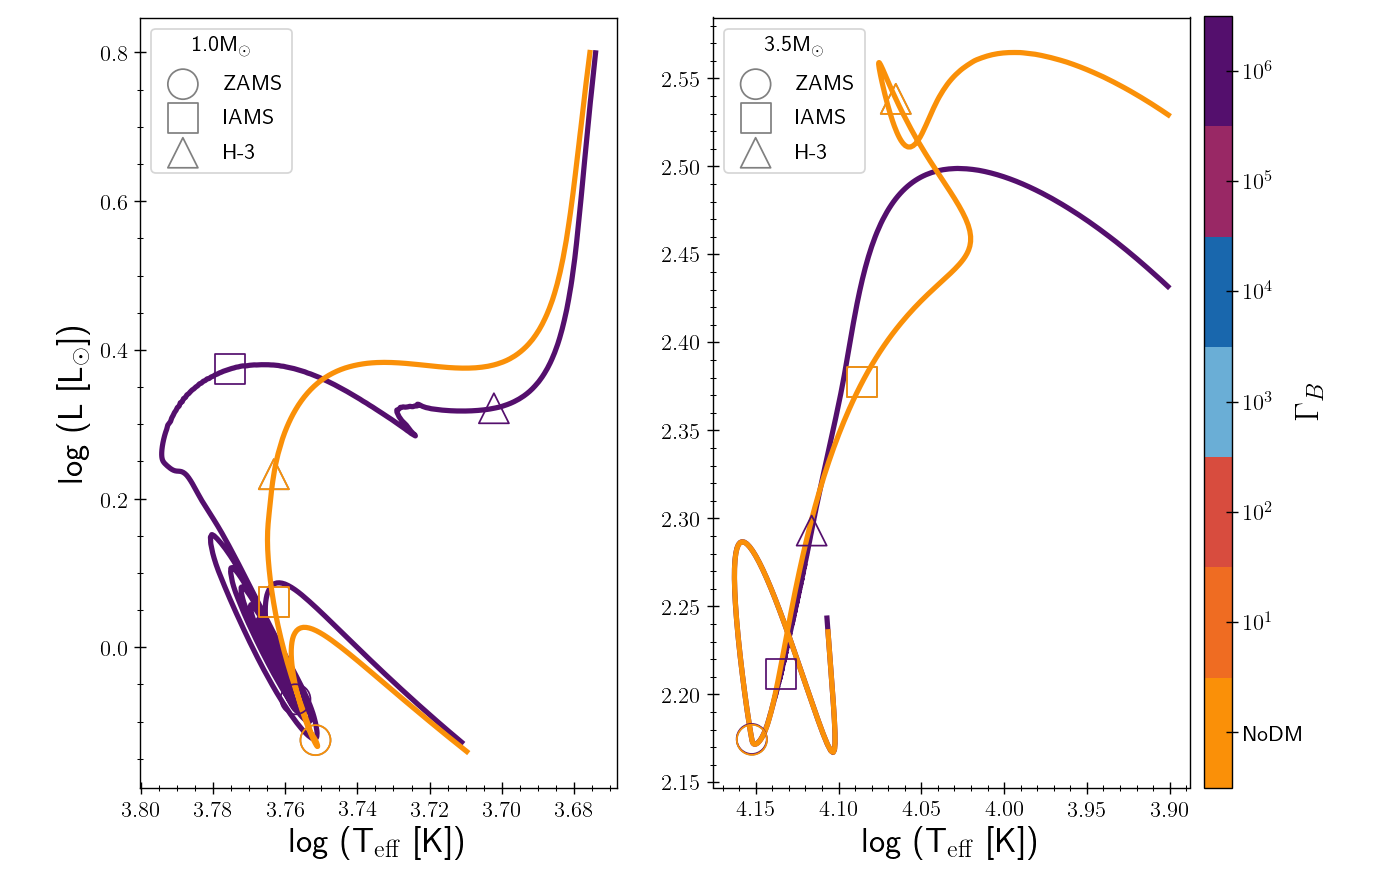


TAMS no model with center_h1 <  1e-12
setting modnum to NaN


In [34]:
plt.rcParams["text.usetex"] = True

# plot_HR(from_file=False, save=None)
plot_HR(from_file=False, cut_axes=True, save=finalplotdir+'/HR.png')
# plot_HR(from_file=False, cut_axes=True, save=plotdir+'/HRcut.png')
# plot_HR(from_file=False, cut_axes=False, save=plotdir+'/HRfull.png')


# Isochrones

In [35]:


def plot_isos(isodf, plot_times=None, cblist=None, save=None):
    """ Plots isochrone panels.
    """
    cbc = [get_cmap_color(c, cmap=cbcmap) for c in range(7) ] # plot colors
    if cblist is None:
        cblist = [0,3,6]

    ntimes = len(plot_times)
    nrows = int(np.ceil(ntimes/2))
    ncols = 2
    
    if save is None:
        f, axs = plt.subplots(nrows=nrows,ncols=ncols,
                              figsize=(4*ncols,5*nrows))
    else:
        f, axs = plt.subplots(nrows=nrows,ncols=ncols,
                              figsize=(savefigw, 1.75*savefigh))
    axs = axs.flatten() # flatten the array for later iteration

        
    # Separate isodf by iso age (subplot)
    agedfg = isodf.groupby('log10_isochrone_age_yr')
    for a, isoage in enumerate(plot_times):
        df = agedfg.get_group(isoage)
        # cut data so axes scale correctly. see function for cut definitions
#         df = get_isoaxes_cuts(df, isoage)
        
        # Separate isodf by cboost
        cbdfg = df.groupby('cboost')
        for i, (cb, icbdf) in enumerate(cbdfg):
            if cb not in cblist: continue
                
#             T = np.array(icbdf.log_Teff); L = np.array(icbdf.log_L)
            axs[a].plot(icbdf.log_Teff, icbdf.log_L, color=cbc[cb])
    
            # Highlight some masses:
#             if cb not in [0,6]: continue # skip this part
            midx_dict = get_midx_dict(icbdf, mtol=1e-1)
            for mkey, midx in midx_dict.items():
                if midx is None: continue
                mrkr = '^' if mkey == 3.5 else 'o'
                kwargs = {'marker':mrkr, 'facecolors':'none', 'edgecolors':cbc[cb], \
                          's':300, 'zorder':-cb+6}
                row = icbdf.loc[midx] # get the correct row from the df
#                     axs[a].scatter(mdf.log_Teff, mdf.log_L, color=cbc[cb], marker=mrkr, s=100)
                axs[a].scatter(row.log_Teff, row.log_L, **kwargs)


        # Axes params
        axs[a].invert_xaxis()
#         axs[a].grid(linestyle='-', linewidth='0.5', color='0.7')

        # Age annotations:
        xpad = 0.05 if isoage>8 else 0.65 # axes from lower left
        ypad = 0.85
        fs = 14
        lbl = get_isoage_label(isoage)
        axs[a].annotate(lbl,(xpad,ypad), fontsize=fs, xycoords='axes fraction')


            
    # Axes labels
        if a%2 == 0:
            axs[a].set_ylabel(r'log (L [L$_{\odot}$])')
    teff = r'log (T$_{\mathrm{eff}}$ [K])'
    axs[-1].set_xlabel(teff)
    axs[-2].set_xlabel(teff)
    
    
#     # Colorbar
    cmapdict = get_cmapdict(cb,len([1]))
    ascat = axs[a].scatter(3.7, 1, marker='+', s=0.01, **cmapdict)
    top=0.98
    f.subplots_adjust(bottom=0.1, top=top, left=0.1, right=0.85, wspace=0.2, hspace=0.2)
    row_frac = 1./(nrows+1)
    cb_ax = f.add_axes([0.86, 3*row_frac, 0.02, 1.75*row_frac]) 
                        # (pushes right, pushes up, width, height)
#     cb_ax = f.add_axes([0.86, 1-row_frac, 0.02, top*row_frac])
    cbar = get_cbcbar(sm=ascat, cax=cb_ax, f=f)

    
#     ####
#     # Colorbar
#     cmapdict = get_cmapdict(cb,len([1]))
#     ascat = axs[a].scatter(4,2.3, marker='+', s=0.01, **cmapdict)
#     top = 0.98
#     f.subplots_adjust(bottom=0.1, top=top, left=0.1, right=0.85, wspace=0.2, hspace=0.2)
#     row_frac = 0.9
#     cb_ax = f.add_axes([0.86, 1-row_frac, 0.2, top*row_frac]) 
#                         # (pushes right, pushes up, width, height)
#     cbar = get_cbcbar(sm=ascat, cax=cb_ax, f=f)
####


#     plt.tight_layout()
    if save is not None: plt.savefig(save)
    plt.show()


In [36]:
# Make isodf
isodf = load_isos_from_file(fin=iso_csv, cols=None)

# Check which iso ages are available for plotting
# get_iso_ages(isodf)

<IPython.core.display.Javascript object>


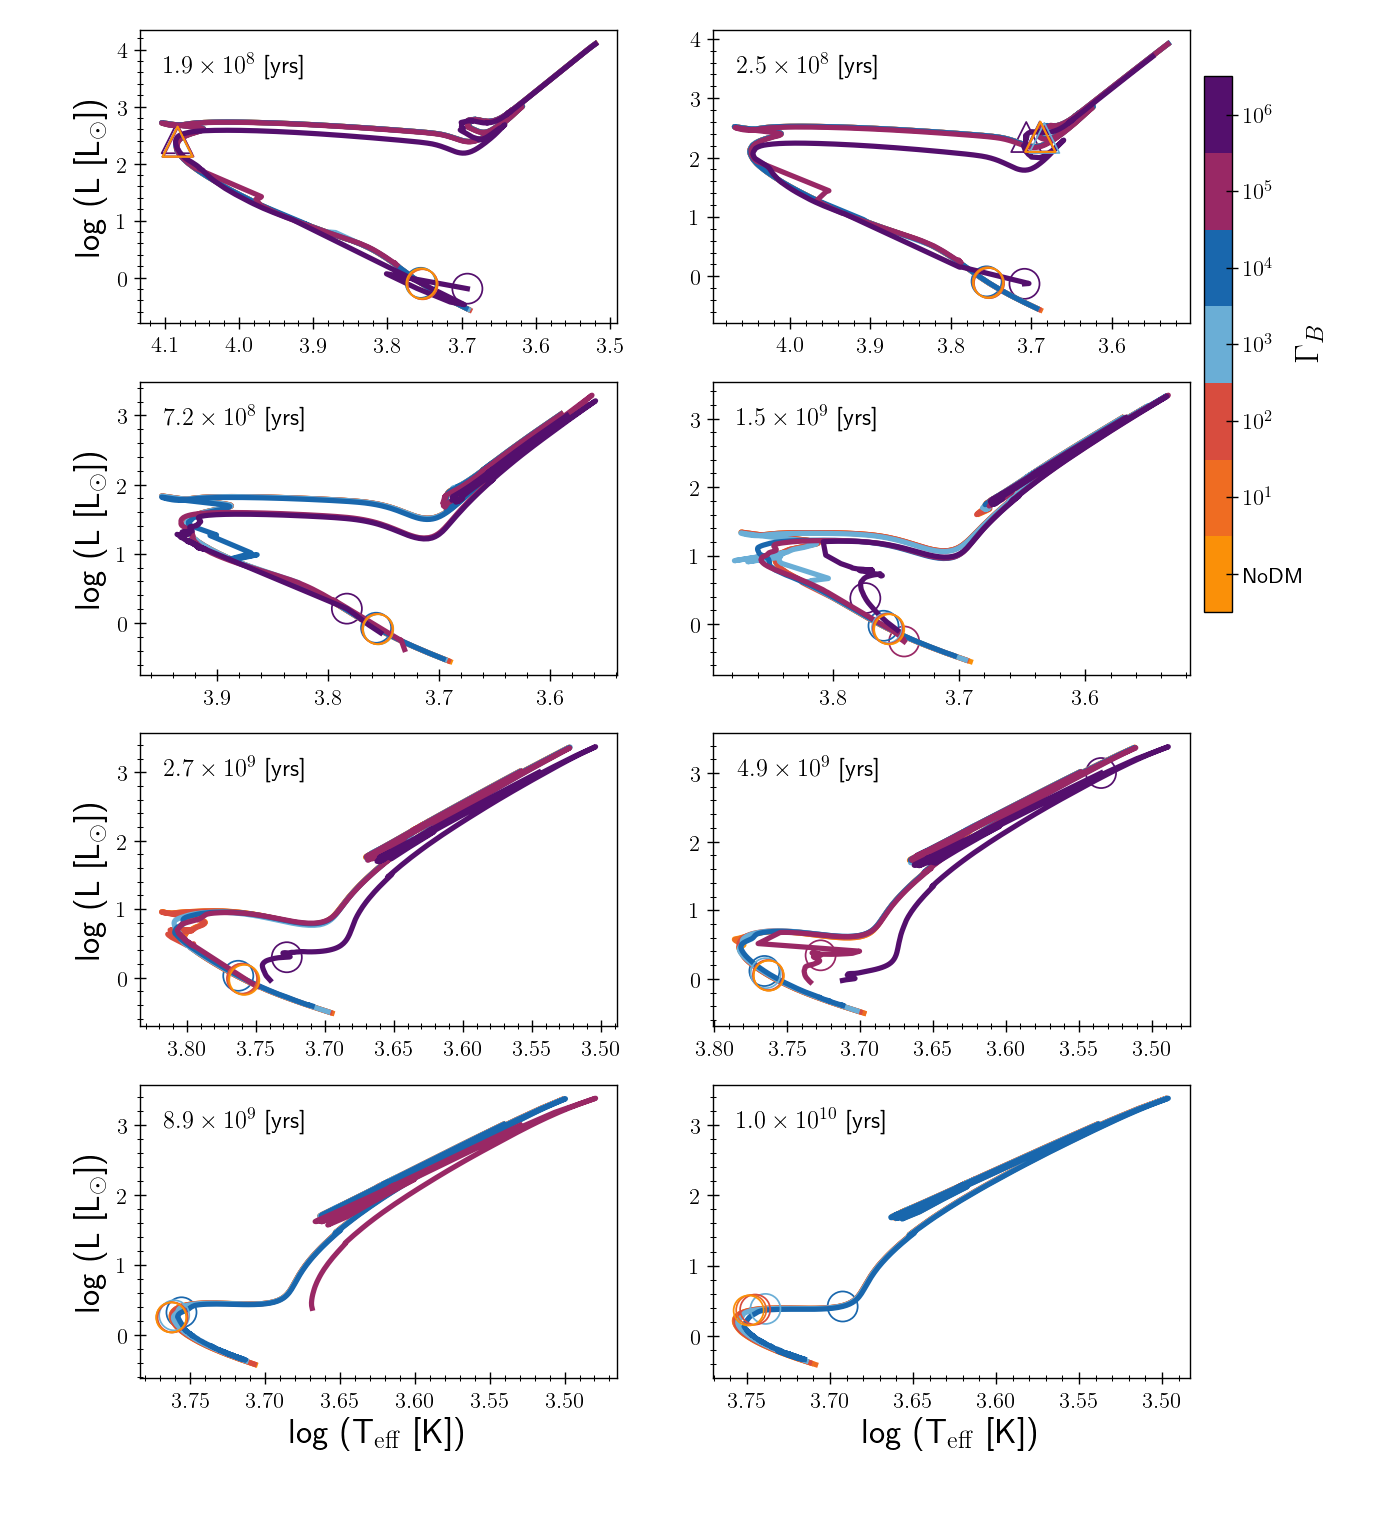

In [37]:
# MAKE THE PLOT

plt.rcParams["text.usetex"] = True

plot_times = [8.284, 8.4124, 8.8618, 9.1828, 9.4396, 9.6964, 9.9532, 10.017400000000002]
cblist = [c for c in range(7)]

plot_isos(isodf, plot_times=plot_times, cblist=cblist, save=finalplotdir+'/isos.png')
# plot_isos(isodf, plot_times=plot_times, cblist=cblist, save=plotdir+'/isos.png')
# plot_isos(isodf, plot_times=plot_times, cblist=None)

# 1.0 Msun

In [ ]:
# GET H1cuts MODEL NUMBERS FROM HISTORY FILE
    # SO THAT I CAN SAVE THE CORRECT PROFILES.

pidxdfOG = get_profilesindex_df()

# hdf = get_hdf(0, mass=1.0)
# get_h1_modnums(frm='history_data', mass=1.0, hdf=hdf, cb=0)

# hdf = get_hdf(3, mass=1.0)
# get_h1_modnums(frm='history_data', mass=1.0, hdf=hdf, cb=3)

hdf = get_hdf(6, mass=1.0)
get_h1_modnums(frm='history_data', mass=1.0, hdf=hdf, cb=6)


In [38]:

def plot_m1p0c6_age(plot_times=None, from_file=False, save=None):
    """ Gets and plots the history.data file.
        from_file should be list [c0,c6] of specific dirs 
                    to get correct history.data with burning cols.
    """

    if plot_times is None:
        plot_times = list(get_osc_modnums().keys())
    ntimes = len(plot_times)

    xlim = (1.9*10**8, 4.*10**8)
    ylim = (0.,0.7)
    ylimtwin = (-0.7, 0.5)
    cb = 6
    burn_zone_colors = ['w', 'darkorange','darkred']
    
    ff = from_file if from_file==False else from_file[0]
    hdf0 = get_hdf(0, mass=1.0, from_file=ff)
    ff = from_file if from_file==False else from_file[1]
    hdf = get_hdf(cb, mass=1.0, from_file=ff)
    
    
    if save is None:
        plt.figure()
    else:
        plt.figure(figsize=(savefigw, savefigh))
    ax = plt.gca()
    axtwin = ax.twinx()

    
    # Plot burning:
    burn_cols0 = get_burn_cols(hdf0)
    bzones0 = burn_cols0.groupby('burn_type', sort=True)
    burn_cols = get_burn_cols(hdf)
    bzones = burn_cols.groupby('burn_type', sort=True)
    for b, (bz, cols) in enumerate(bzones):
        c = burn_zone_colors[bz]
        alph = 0.7
#         icols = interp_burn_cols(cols, xlim) # SLOW WITH MINIMAL EFFECT
        icols=cols
        ax.fill_between(icols.star_age, icols.mass_bottom, y2=icols.mass_top, 
                        step='mid', color=c, alpha=alph)
        cols0 = bzones0.get_group(bz).sort_values('star_age')
#         icols0 = interp_burn_cols(cols0)
        ax.plot(cols0.star_age, cols0.mass_top, color=c)
    
    
    # Plot osc times vlines:
    oscmods = get_osc_modnums() # dict
    om_names = list(get_osc_modnums().keys())
    # For osc times annotations:
    anny = ylim[1] - 0.05
    r = -90
    tdlta = 5e6
    fs = 10
    for t, tname in enumerate(om_names):
        if tname not in plot_times: continue
        tmod = oscmods[tname]
        tage = hdf[hdf.model_number==tmod].star_age.values[0]
        plt.axvline(tage, lw=0.5, c='k')
        # Osc times annotations:
        rot = -r if tname == 'Time5' else r
        td = 1.5*tdlta if tname=='Degen' else (0 if tname=='Time5' else tdlta)
        ax.annotate(tname,(tage-td,anny), rotation=rot, fontsize=fs)

    # Plot L
    Lc = 'b'
    axtwin.plot(hdf.star_age, hdf.log_L, color=Lc)
    axtwin.plot(hdf.star_age, hdf.log_LH, color=Lc, ls=':')
    axtwin.set_ylim(ylimtwin)
    axtwin.tick_params(axis='y', colors=Lc)
    axtwin.set_ylabel(r'log(L [L$_{\odot}$])', color=Lc)
    
    
    # Axes params:
    ax.semilogx()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r'Star Age [yrs]')
    ax.set_ylabel(r'mass($<$r)')

    mpl.rcParams['xtick.direction'] = 'out'
    mpl.rcParams['ytick.direction'] = 'out'
    
    plt.tight_layout()
    if save is not None: plt.savefig(save)
    plt.show()

    



Loading m1.0c0 history df from file. Looking for path...
Getting get_profilesindex_df()...
Skipping c3 dir m1p00_stopmod1
Found requested dir:  m1p00_stopmod1000
Loading history df from path /Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c0/m1p00_stopmod1000/LOGS/history.data

Loading m1.0c6 history df from file. Looking for path...
Getting get_profilesindex_df()...
Skipping c3 dir m1p00_stopmod1
Found requested dir:  m1p00_stopmod2000
Loading history df from path /Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c6/m1p00_stopmod2000/LOGS/history.data



<IPython.core.display.Javascript object>


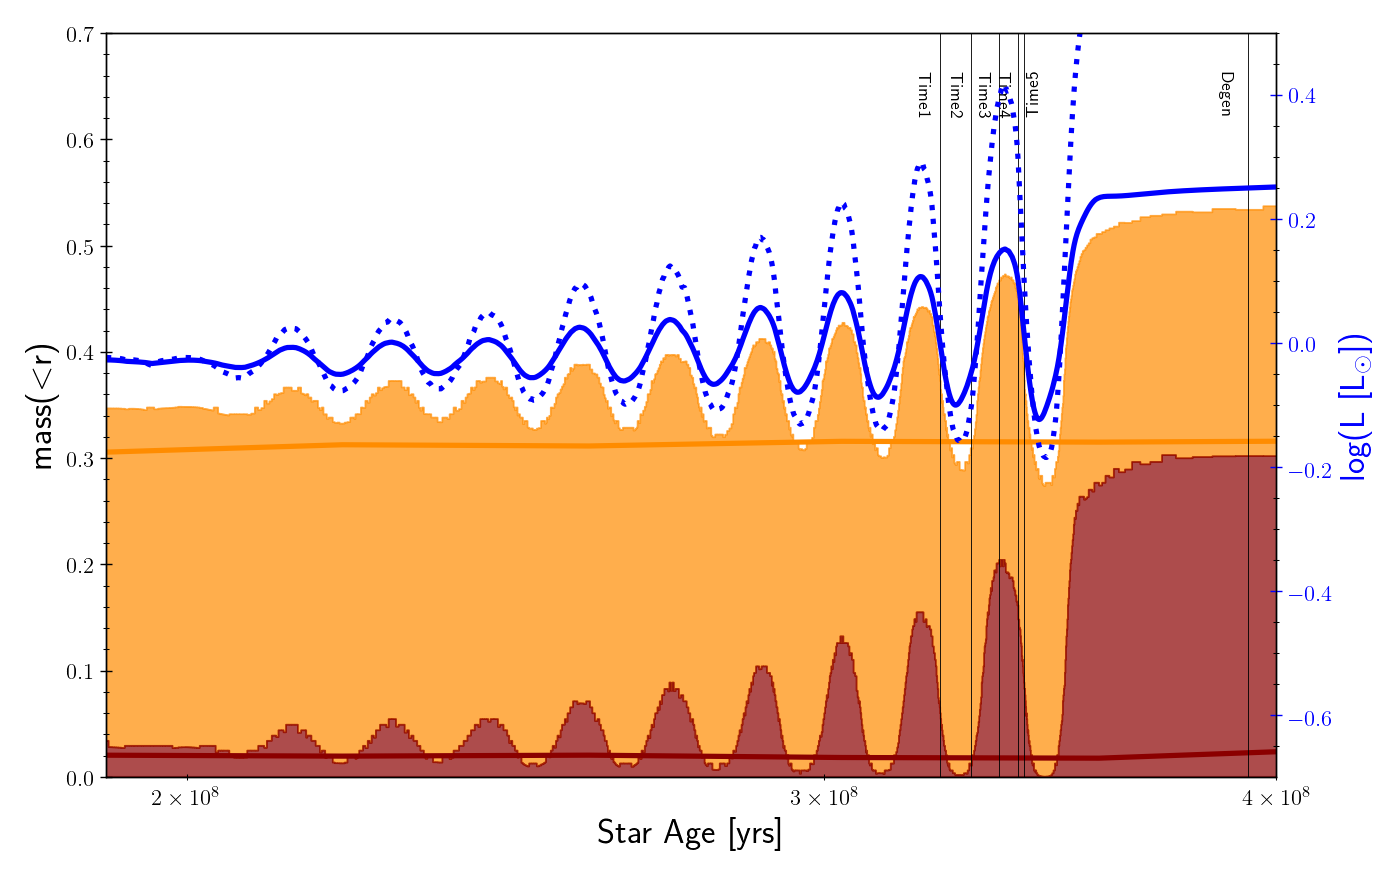

/Users/troyraen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: 'star_age' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


In [39]:
# Make the plot

plt.rcParams["text.usetex"] = True
plot_times = [ 'Time1', 'Time2', 'Time3', 'Time4', 'Time5', 'Degen' ]
from_file = ['m1p00_stopmod1000', 'm1p00_stopmod2000'] # need dirs with burning columns

plot_m1p0c6_age(plot_times=plot_times, from_file=from_file, save=finalplotdir+ '/m1p0c6_age.png')
# plot_m1p0c6_age(plot_times=plot_times, from_file=False, save=plotdir+ '/m1p0c6_age.png')
# plot_m1p0c6_age(plot_times=plot_times, from_file=from_file)

In [40]:
def plot_m1p0c6(plot_times=None, save=None):
    """ cbmods = ordered list of lists of model numbers to plot
            as returned by get_h1_modnums()
        plot_times = list of oscilation times (names defined in get_osc_modnums()) to plot
    """
    xmax = 0.25
    cb = 6
    
#     plot_times=None
    if plot_times is None:
        plot_times = list(get_osc_modnums().keys())
    ntimes = len(plot_times)
    
#     cbc = get_cmap_color(cb, cmap=cbcmap) # plot colors
    cl = 'maroon' # left axis color
    cr = 'darkblue' # right axis color
    
    # For annotations:
     # placement for extra heat arrows:
    delth = 0.015; deltv = 1.5
    l = 0.19; r = l + delth; b = 20; t = b + deltv
    xarws = [[(r,b),(l,t)], 
             [(r,b+10),(l,t+10)], 
             [(r,b+35),(l,t+35)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)]]
     # placement for nuclear burning arrows
    r = l; l = r - delth; b = 10; t = b + deltv
    narws = [[(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)]]

    ncols = 2
    if save is None:
        f, axs = plt.subplots(nrows=ntimes,ncols=ncols, sharex=True)
    else:
        f, axs = plt.subplots(nrows=ntimes,ncols=ncols, sharex=True, 
                                                          figsize=(savefigw, savefigh+6))
    axtwin = [ [axs[t,0].twinx() for t in range(ntimes)],
                [axs[t,1].twinx() for t in range(ntimes)] ]

    a = -1
    oscmods = get_osc_modnums() # dict
    om_names = list(get_osc_modnums().keys())
    for t, tname in enumerate(om_names):
        if tname not in plot_times:
            continue
        else:
            a = a+1
            
        print(cb, oscmods[tname])
        print()
        d = get_pdf(cb, oscmods[tname], mass=1.0)
        d = d[d.mass<xmax] # slice the portion that will be visible so axes scale correctly

        # Plot nuclear energy (use arrays to avoid auto generating legend label):
        axs[a,0].plot(np.array(d.mass), np.array(d.eps_nuc_plus_nuc_neu), c=cl)#, zorder=-i+6)

        # Plot Temperature:
        xfrac_lbl = get_xfrac_lbl(d)
#         tmtx = (10**d.logT - d.wimp_temp)/ 1e7
#         axs[a,1].plot(np.array(d.mass), np.array(tmtx), c=cbc)#, label=xfrac_lbl)
        axs[a,1].plot(np.array(d.mass), np.array(d.logT), c=cl)#, label=xfrac_lbl)
#         axs[a,1].legend() # show xfrac legend

        # Plot logRho:
        axtwin[1][a].plot(np.array(d.mass), np.array(d.logRho), c=cr)

        # Plot wimp temp:
        xls = {'ls':':', 'lw':1}
#         axs[a,1].plot(np.array(d.mass), 0*np.array(d.mass), c=cbc, **xls)
        axs[a,1].plot(np.array(d.mass), np.array(np.log10(d.wimp_temp)), c=cl, **xls)

        # Plot extra heat:
        axtwin[0][a].plot(d.mass, d.extra_heat, c=cr)
        axtwin[0][a].plot(d.mass, 0*d.mass, c=cr, lw=0.5) # horizontal line at 0
        
        # Set axis colors:
        for itmp in range(ncols):
            axs[a,itmp].tick_params(axis='y', colors=cl)
#         axs[a,1].spines['left'].set_color(cl)
            axtwin[itmp][a].tick_params(axis='y', colors=cr)


        
        # Annotate with times:
        time_name = tname if (plt.rcParams["text.usetex"]==False) else r'$\textbf{'+tname+'}$'
        axs[a,0].annotate(time_name, (1.05,1.), xycoords='axes fraction', 
                          annotation_clip=False, **{'fontweight':'bold'})
            
#         # Annotate with arrows:
#         ap = {'arrowstyle':"->", 'connectionstyle':"angle,angleA=90,angleB=0", 'alpha':0.5}
#         axs[a,0].annotate('',xarws[t][0], xytext=xarws[t][1], arrowprops=ap)
#         axs[a,0].annotate('',narws[t][0], xytext=narws[t][1], arrowprops=ap)

    # Set axis limits:
        axs[a,0].set_ylim(0,32)
        axtwin[0][a].set_ylim(-225,445)
        axs[a,1].set_ylim(7.03,7.11)
        axtwin[1][a].set_ylim(1.6,2.45)
    # set bottom axes limits
    for itmp in range(ncols):
#         axs[a,itmp].relim()        
        axs[a,itmp].autoscale(axis='y', tight=False)
        axtwin[itmp][a].autoscale(axis='y', tight=False)
    axs[a,0].set_xlim(-0.0,xmax)
    axs[a,1].set_xlim(-0.0,xmax)

    # Set energy legend:
    axs[1,0].plot(d.mass.iloc[0], d.eps_nuc_plus_nuc_neu.iloc[0], c=cl, label=r'$\epsilon_{nuc}$ [erg/g/s]')
    axs[1,0].plot(d.mass.iloc[0], d.extra_heat.iloc[0], c=cr, label=r'$\epsilon_{\chi}$ [erg/g/s]')
    axs[1,0].legend(loc='upper right')

    # Set temp/rho legend:
    axs[1,1].plot(-1, 7.1, c=cl, label=r'log(T [K])')
    axs[1,1].plot(-1, 7.1, c=cl, **xls, label=r'log(T$_{\chi}$ [K])')
    axs[1,1].plot(-1, 7.1, c=cr, label=r'log(Rho [g/cm3])')
    axs[1,1].legend(loc='upper right')
    
    
    # Labels and titles
    axs[a,0].set_xlabel(r'$mass(<r)/M_{\odot}$')
    axs[a,1].set_xlabel(r'$mass(<r)/M_{\odot}$')

    # Tick directions
    mpl.rcParams['xtick.direction'] = 'out'
    mpl.rcParams['ytick.direction'] = 'out'
    
#     plt.subplots_adjust(top = 2.0)
    plt.tight_layout()

    if save is not None: plt.savefig(save)
    plt.show()


<IPython.core.display.Javascript object>


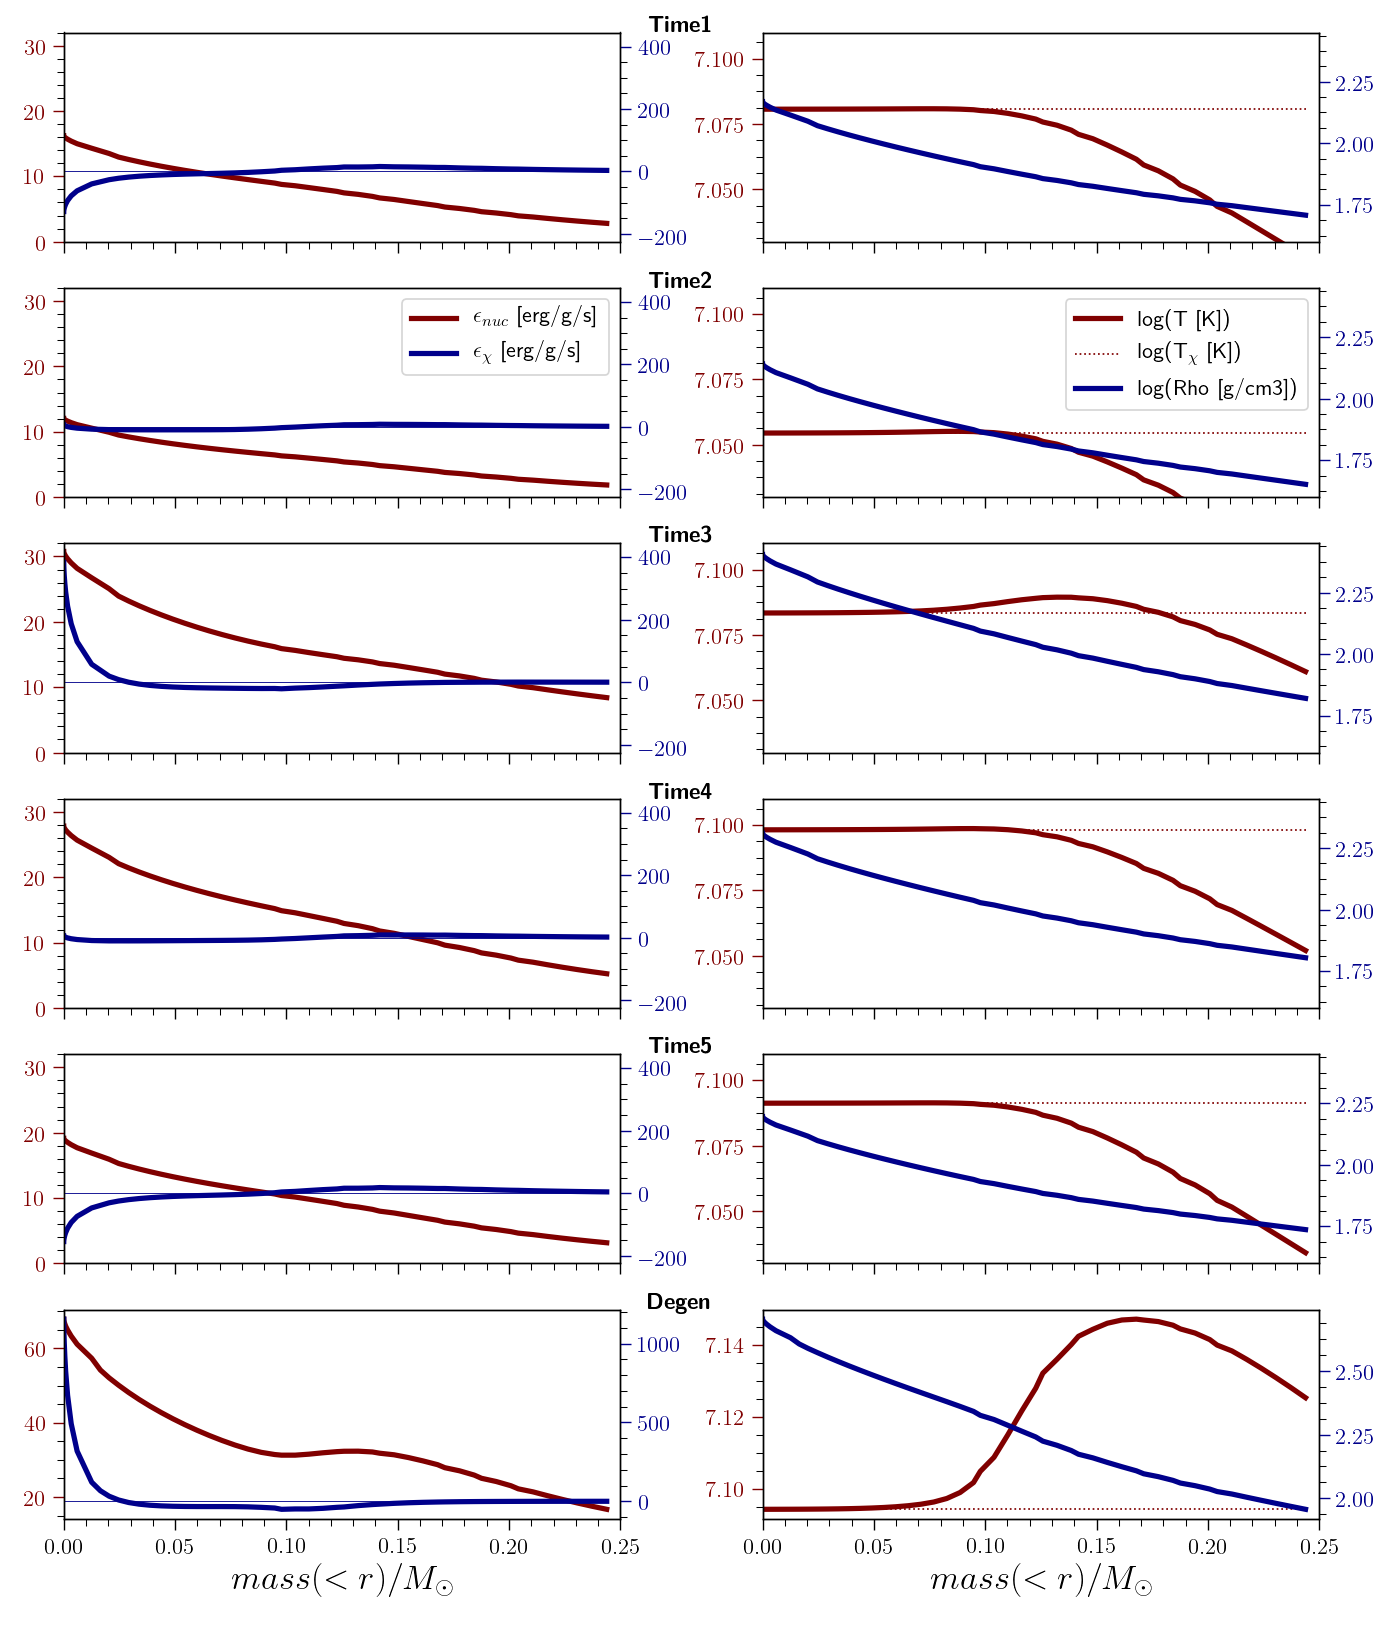

6 1679

6 1720

6 1759

6 1780

6 1791

6 1909



In [42]:
# MAKE m1p0c6 PLOT

# pidxdfOG = get_profilesindex_df()

plt.rcParams["text.usetex"] = True
plot_times = [ 'Time1', 'Time2', 'Time3', 'Time4', 'Time5', 'Degen' ]

plot_m1p0c6(plot_times=plot_times, save=finalplotdir+ '/m1p0c6.png')

In [43]:
def plot_m1p0c3(peeps=None, save=None):
    """ cbmods = ordered list of lists of model numbers to plot
            as returned by get_h1_modnums()
        peeps = list of h1cuts (names defined in get_h1cuts()) to plot
    """
    xmax = 0.21
    cb = 3

    cbmods = get_h1_modnums(mass=1.0)
    c0mods = cbmods[0]
    c3mods = cbmods[cb]
    
    if peeps is None:
        peeps = list(get_h1cuts().keys())
    ntimes = len(peeps)

    cbc = [get_cmap_color(0, cmap=cbcmap), get_cmap_color(cb, cmap=cbcmap)] # plot colors

    # For annotations:
     # placement for extra heat arrows:
    delth = 0.015; deltv = 1.5
    l = 0.19; r = l + delth; b = 20; t = b + deltv
    xarws = [[(r,b),(l,t)], 
             [(r,b+10),(l,t+10)], 
             [(r,b+35),(l,t+35)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)]]
     # placement for nuclear burning arrows
    r = l; l = r - delth; b = 10; t = b + deltv
    narws = [[(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)]]

    if save is None:
        f, axs = plt.subplots(nrows=ntimes,ncols=2, sharex=True)
    else:
        f, axs = plt.subplots(nrows=ntimes,ncols=2, sharex=True, 
                              figsize=(savefigw, savefigh+2))
    axtwin = [axs[t,0].twinx() for t in range(ntimes)]

    a = -1
    h1c_names = list(get_h1cuts().keys())
    for t, peep in enumerate(h1c_names):
        if peep not in peeps:
            continue
        else:
            a = a+1
#             print(peep)
            
        df = [ get_pdf(0, c0mods[t], mass=1.0), get_pdf(cb, c3mods[t], mass=1.0) ] # dataframes
        
        for i, d in enumerate(df):
            d = d[d.mass<xmax] # slice the portion that will be visible so axes scale correctly
            # Plot nuclear energy (use arrays to avoid auto generating legend label):
            axs[a,0].plot(np.array(d.mass), np.array(d.eps_nuc_plus_nuc_neu), ls='--', c=cbc[i])#, zorder=-i+6)
            # Plot Temperature:
            xfrac_lbl = get_xfrac_lbl(d)
            axs[a,1].plot(np.array(d.mass), np.array(d.logT), c=cbc[i], label=xfrac_lbl)
        # Plot wimp temp:
        xls = {'ls':'-.', 'lw':1}
        axs[a,1].plot(np.array(df[1].mass), np.array(np.log10(df[1].wimp_temp)), c=cbc[i], **xls)
        # Plot extra heat:
        axtwin[a].plot(df[1].mass, df[1].extra_heat, c=cbc[i])
        
        axs[a,1].legend() # show xfrac legend
        # Annotate with times:
        time_name = peep if (plt.rcParams["text.usetex"]==False) else r'$\textbf{'+peep+'}$'
        axs[a,0].annotate(time_name, (1.05,1.), xycoords='axes fraction', 
                          annotation_clip=False, **{'fontweight':'bold'})
            
        # Annotate with arrows:
        ap = {'arrowstyle':"->", 'connectionstyle':"angle,angleA=90,angleB=0", 'alpha':0.5}
        axs[a,0].annotate('',xarws[t][0], xytext=xarws[t][1], arrowprops=ap)
        axs[a,0].annotate('',narws[t][0], xytext=narws[t][1], arrowprops=ap)

        # Set axis limits:
        axs[a,0].set_xlim(-0.0,xmax)
        axs[a,1].set_xlim(-0.0,xmax)
#         axs[t,1].set_ylim(7.0,7.4)

    # Set energy legend:
    axs[0,0].plot(d.mass.iloc[0], d.eps_nuc_plus_nuc_neu.iloc[0], ls='--', c='0.5', label=r'$\epsilon_{nuc}$ [erg/g/s]')
    axs[0,0].plot(d.mass.iloc[0], d.extra_heat.iloc[0], c='0.5', label=r'$\epsilon_{\chi}$ [erg/g/s]')
    axs[0,0].legend(loc='center')

    # Set temp legend:
#     axs[0,1].plot(d.mass.iloc[0], d.logT.iloc[0], c='0.5', label=r'log(T [K])')
#     axs[0,1].plot(d.mass.iloc[0], np.log10(d.wimp_temp.iloc[0]), c='0.5', **xls, label=r'log(T$_{\chi}$ [K])')
    axs[0,1].plot(-1, 7.1, c='0.5', label=r'log(T [K])')
    axs[0,1].plot(-1, 7.1, c='0.5', **xls, label=r'log(T$_{\chi}$ [K])')
    axs[0,1].legend(loc='best')
    
    
    # Labels and titles
    axs[a,0].set_xlabel(r'$mass(<r)/M_{\odot}$')
    axs[a,1].set_xlabel(r'$mass(<r)/M_{\odot}$')

    # Tick directions
    mpl.rcParams['xtick.direction'] = 'out'
    mpl.rcParams['ytick.direction'] = 'out'
    
#     plt.subplots_adjust(hspace = 0.5)
    plt.tight_layout()

    if save is not None: plt.savefig(save)
    plt.show()


<IPython.core.display.Javascript object>


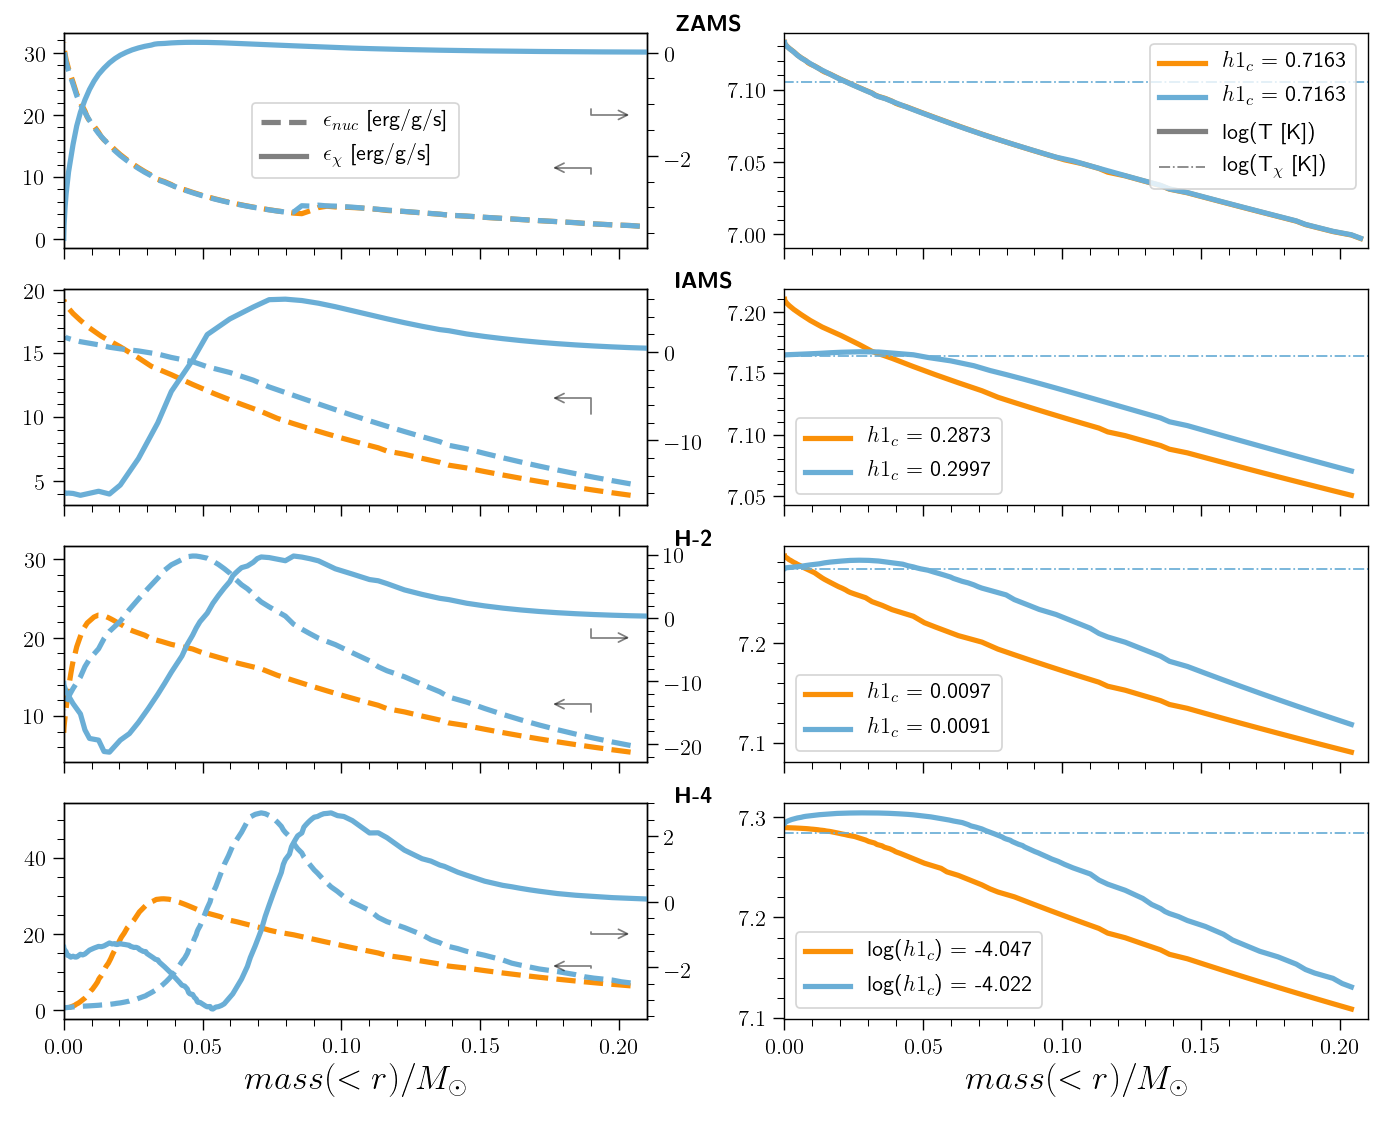

Found 3 rows matching input m1.0 c0 mod757. Paths are:                 
[ '/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c0/m1p00_stopmod1/LOGS'
 '/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c0/m1p00_stopmod865/LOGS'
 '/Users/troyraen/Osiris/mesaruns/RUNS_2test_final/profile_runs/c0/m1p00_stopmod1000/LOGS']

Using the last.


In [48]:
# MAKE m1p0c3 PLOT

# pidxdfOG = get_profilesindex_df()

plt.rcParams["text.usetex"] = True
peeps = [ 'ZAMS', 'IAMS', 'H-2', 'H-4' ]

plot_m1p0c3(peeps=peeps, save=finalplotdir+ '/m1p0c3.png')


# 3.5 Msun Profiles

load all files profiles.index
    pidxdf cols { mass, cb, path_to_LOGS, priority, model_number, profile_number }
    
input mass, cb, model_number
    get profile data loaded into a dataframe
    
when plotting, call mass, cb, model_number
    get 

In [45]:
# c0mods=[775,856,949]
# c6mods=[775,1557,1683]

def plot_m3p5(peeps=None, save=None):
    """ cbmods = ordered list lists of model numbers to plot
            as returned by get_h1_modnums()
        peeps = list of h1cuts (names defined in get_h1cuts()) to plot
    """
    
    xmax = 0.95
    cb = 6

    cbmods = get_h1_modnums(mass=3.5)
    c0mods = cbmods[0]
    c6mods = cbmods[cb]
    
    if peeps is None:
        peeps = list(get_h1cuts().keys())
    ntimes = len(peeps)

    cbc = [get_cmap_color(0, cmap=cbcmap), get_cmap_color(cb, cmap=cbcmap)] # plot colors

    # For annotations:
     # placement for extra heat arrows:
    delth = 0.05; deltv = 300
    l = 0.90; r = l + delth; b = 2700; t = b + deltv
    xarws = [[(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)], 
             [(r,b),(l,t)]]
     # placement for nuclear burning arrows
    r = l; l = r - delth; b = 100; t = b + deltv
    narws = [[(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)], 
             [(l,t),(r,b)]]

    if save is None:
        f, axs = plt.subplots(nrows=ntimes,ncols=2, sharex=True)
    else:
        f, axs = plt.subplots(nrows=ntimes,ncols=2, sharex=True, 
                              figsize=(savefigw, savefigh+2))
    axtwin = [axs[t,0].twinx() for t in range(ntimes)]

    a = -1
    h1c_names = list(get_h1cuts().keys())
    for t, peep in enumerate(h1c_names):
        c0mod = c0mods[t]
        c6mod = c6mods[t]
        if peep not in peeps:
            continue
        elif math.isnan(c0mod) or math.isnan(c6mod):
            continue
        else:
            a = a+1 # iterate axs row

        df = [ get_pdf(0, c0mod), get_pdf(cb, c6mod) ] # dataframes
        
        for i, d in enumerate(df):
            d = d[d.mass<xmax] # slice the portion that will be visible so axes scale correctly

            # Plot nuclear energy (use arrays to avoid auto generating legend label):
            axs[a,0].plot(np.array(d.mass), np.array(d.eps_nuc_plus_nuc_neu), ls='--', c=cbc[i])#, zorder=-i+6)

            # Plot mixing:
            xfrac_lbl = get_xfrac_lbl(d)
            log_D = np.log10(10**d.log_D_conv + 10**d.log_D_ovr)
            axs[a,1].plot(d.mass, log_D, c=cbc[i], label=xfrac_lbl)
#             axs[a,1].plot(d.mass, np.log10(d.np), c=cbc[i], label=xfrac_lbl)

        # Plot extra heat:
        axtwin[a].plot(df[1].mass, df[1].extra_heat, c=cbc[i])
        
        axs[a,1].legend(loc='best') # show xfrac legend
        # Annotate with times:
        time_name = peep if (plt.rcParams["text.usetex"]==False) else r'$\textbf{'+peep+'}$'
        axs[a,0].annotate(time_name, (1.05,1.), xycoords='axes fraction', 
                          annotation_clip=False, **{'fontweight':'bold'})
            
        # Annotate with arrows:
        ap = {'arrowstyle':"->", 'connectionstyle':"angle,angleA=90,angleB=0", 'alpha':0.5}
        axs[a,0].annotate('',xarws[t][0], xytext=xarws[t][1], arrowprops=ap)
        axs[a,0].annotate('',narws[t][0], xytext=narws[t][1], arrowprops=ap)

        # Set axis limits:
        axs[a,0].set_xlim(-0.0,xmax)
        axs[a,1].set_ylim(-1,17)

    # Set energy legend:
    axs[0,0].plot(d.mass.iloc[0], d.eps_nuc_plus_nuc_neu.iloc[0], ls='--', c='0.5', label=r'$\epsilon_{nuc}$ [erg/g/s]')
    axs[0,0].plot(d.mass.iloc[0], d.extra_heat.iloc[0], c='0.5', label=r'$\epsilon_{\chi}$ [erg/g/s]')
    axs[0,0].legend(loc='center')

    # Set mixing legend:
    axs[0,1].plot(d.mass.iloc[0], d.log_D_conv.iloc[0], c='0.5', 
                  label=r'Convective Mixing\\log(diff. coef [cm$^2$/s])')
    axs[0,1].legend(loc='center')
    
    
    # Labels and titles
    axs[a,0].set_xlabel(r'$mass(<r)/M_{\odot}$')
    axs[a,1].set_xlabel(r'$mass(<r)/M_{\odot}$')

    # Tick directions
    mpl.rcParams['xtick.direction'] = 'out'
    mpl.rcParams['ytick.direction'] = 'out'
    
#     plt.subplots_adjust(hspace = 0.5)
    plt.tight_layout()

    if save is not None: plt.savefig(save)
    plt.show()


<IPython.core.display.Javascript object>


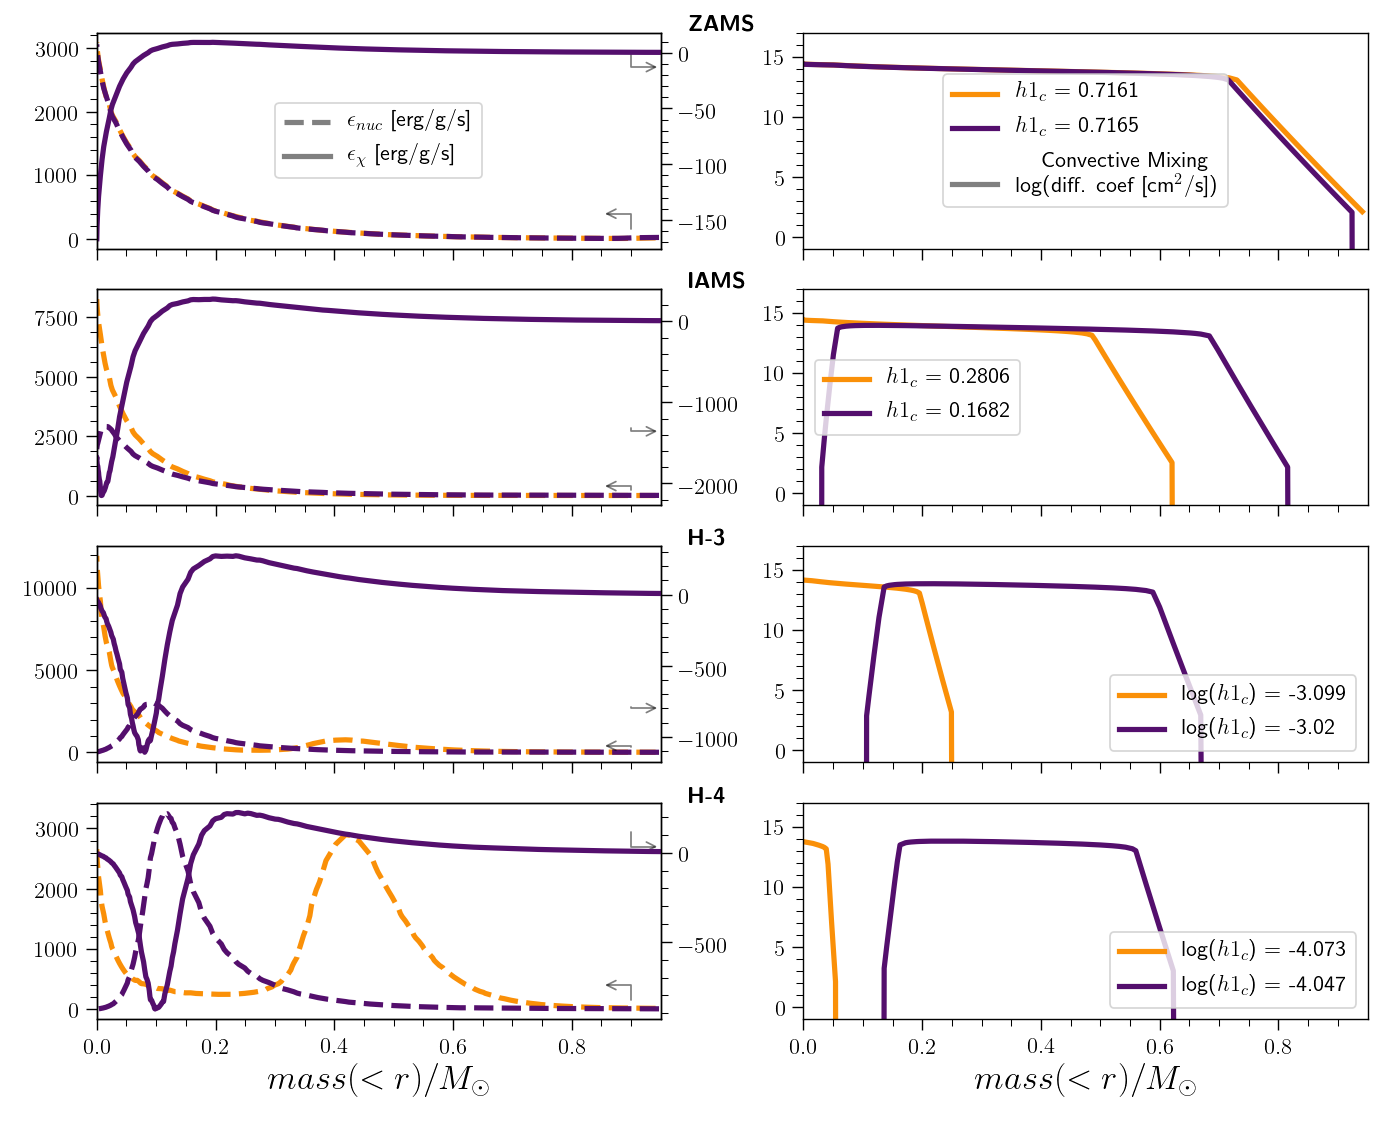

In [47]:
# MAKE THE PLOT

# cbmods = get_h1_modnums(mass=3.5)
# print(cbmods)

plt.rcParams["text.usetex"] = True
peeps = [ 'ZAMS', 'IAMS', 'H-3', 'H-4' ]

plot_m3p5(peeps=peeps, save=finalplotdir+'/m3p5.png')

# delta Tau

In [51]:
def get_descdf(fin=fdesc):
    
    descdf = pd.read_csv(fin)
    
    print('fixing mass precision in {}'.format(fin))
    descdf = fix_desc_mass(descdf) # fix problem with mass precision
    descdf.set_index('star_index', inplace=True)
    
    return descdf


In [49]:
def plot_delta_tau(descdf, save=None):
    if save is None:
        plt.figure()
        mnum=5e2
    else:
        plt.figure(figsize=(savefigw, savefigh))
        mnum=1e4
    ax = plt.gca()
    cbgroup = descdf.sort_values('mass').groupby(('cboost'))
    for i, (cb,dat) in enumerate(cbgroup):
        if cb == 0:
            continue
        mass, mst = interp_mstau(dat.mass, dat.MStau, mnum=mnum)
        cmapdict = get_cmapdict(cb,len(mass))
        plt.scatter(mass,mst(mass), s=5, **cmapdict)
#         plt.scatter(dat.mass,dat.MStau, c=cb*np.ones(len(dat.mass)), cmap=cbcmap, vmin=0, vmax=6, s=10)

#         color = get_cmap_color(cb)
#         plt.plot(mass,mst(mass), color=color)
#         plt.plot(dat.mass,dat.MStau, color=color)

    plt.axhline(0., color=get_cmap_color(0), lw=1)
    cbar = get_cbcbar()

#     Axes
    plt.minorticks_on()

    plt.xlabel(r'Mass [M$_{\odot}$]')
    plt.ylabel(r'$\Delta \tau_{MS}\ /\ \tau_{MS,NoDM}$')
#     plt.ylabel(r'$\frac{\Delta \tau_{MS}}{\tau_{MS,\ Fid}}$')
#     plt.title('Change in Main Sequence Lifetimes')
    plt.tight_layout()
    if save is not None: plt.savefig(save)
    plt.show()
    
    

def interp_mstau(mass, MStau, mnum=1e3):
    mst = interp1d(mass,MStau)
    mass = np.linspace(0.8,5.0,int(mnum))
    return [mass, mst]


In [60]:
# get the descdf
descdf = get_descdf(fin=fdesc)

fixing mass precision in /Users/troyraen/Osiris/mesaruns/RUNS_2test_final/plotsdata/Glue/descDF_MS_allmassesreg.csv


<IPython.core.display.Javascript object>


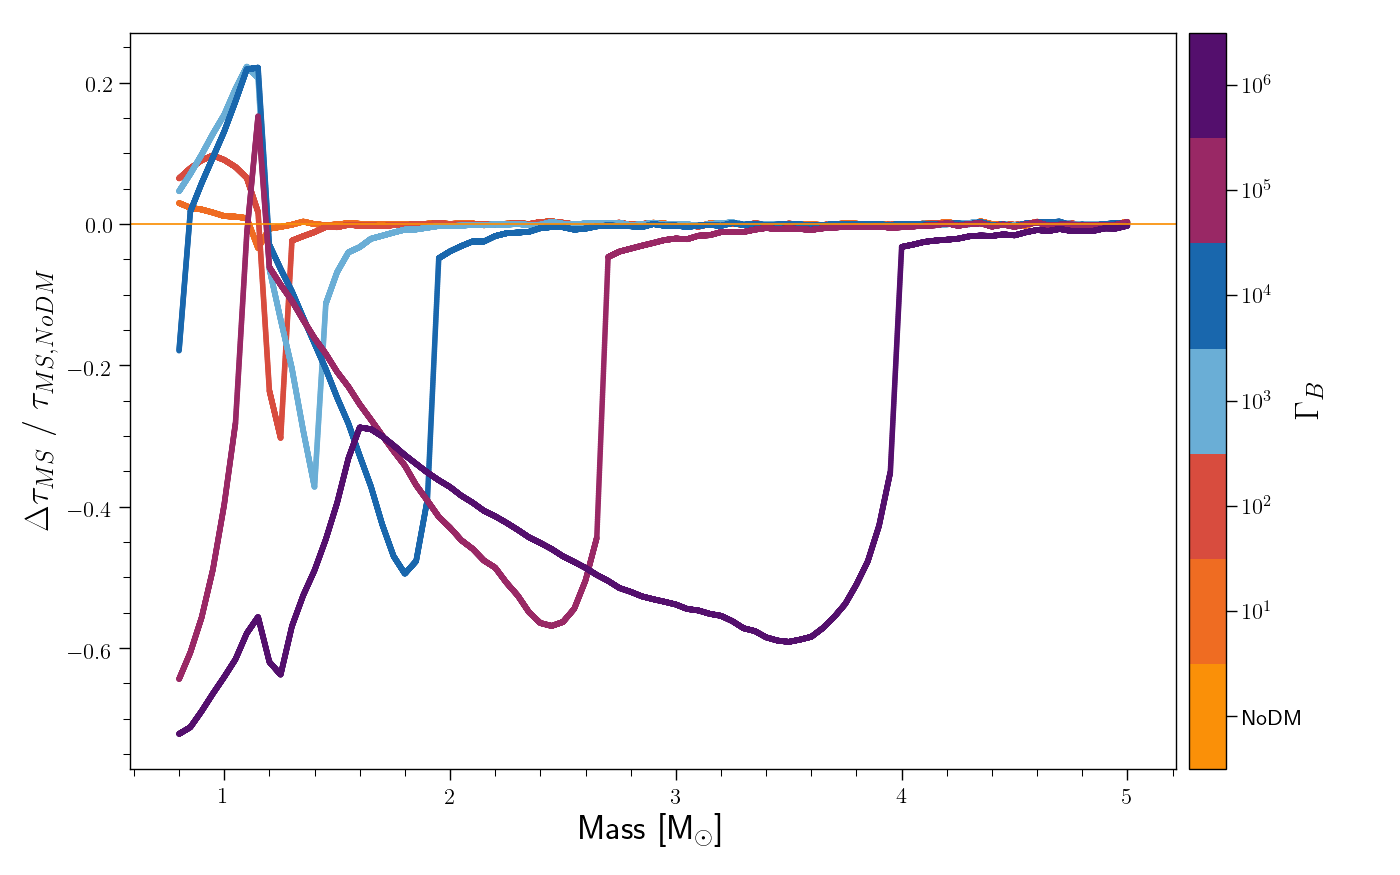

In [61]:
# Make the plot

plt.rcParams["text.usetex"] = True

# plot_delta_tau(descdf)
plot_delta_tau(descdf, save=finalplotdir+'/mstau.png')
